Ссылка:
https://www.kaggle.com/t/9c9b62ef8f964ef6ba475708c652a441

Попробуйте обучить сверточную нейронную сеть, используя обучение с нуля или файнтюнинг. Вы можете воспользоваться сторонними библиотеками для вашей работы.

In [1]:
import os
import json
import time
import random
from dataclasses import dataclass, asdict
from typing import Dict, Any, Tuple, List

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import math
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from torchvision import transforms, models
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

C:\Users\user\PycharmProjects\trader\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# для воспроизводимости
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Загрузка данных

In [4]:
ROOT_DATA_PATH = r"data/one-piece-classification-2025"
TRAIN_DIR = os.path.join(ROOT_DATA_PATH, "splitted", "train")
TEST_DIR = os.path.join(ROOT_DATA_PATH, "splitted", "test")
LABELS_PATH = os.path.join(ROOT_DATA_PATH, "labels.json")

IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg", ".bmp", ".webp")

In [5]:
def load_label_mapping(labels_path: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Строит маппинг:
    - name2id: имя класса -> id (int)
    - id2name: id (int) -> имя класса
    """
    with open(labels_path, "r", encoding="utf-8") as f:
        raw_mapping = json.load(f)

    id2name = {int(idx): name for idx, name in raw_mapping.items()}
    name2id = {name: idx for idx, name in id2name.items()}
    return name2id, id2name


In [6]:
# разметка данных
name2id, id2name = load_label_mapping(LABELS_PATH)

## Инициализация датасета

In [7]:
class OnePieceImageDataset(Dataset):
    """
    Датасет, возвращает (PIL.Image, int label)"""

    def __init__(self, root_dir: str, name2id: Dict[str, int]) -> None:
        self.root_dir = root_dir
        self.name2id = name2id
        self.samples: List[Tuple[str, int]] = []

        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label_id = name2id[class_name]
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(IMAGE_EXTENSIONS):
                    path = os.path.join(class_dir, fname)
                    self.samples.append((path, label_id))

        if len(self.samples) == 0:
            raise RuntimeError(f"No image files found in {root_dir}")

        print(f"Loaded {len(self.samples)} samples from {root_dir}")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, int]:
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return img, label


In [8]:
train_dataset = OnePieceImageDataset(TRAIN_DIR, name2id)

Loaded 2915 samples from data/one-piece-classification-2025\splitted\train


Индекс: 2619


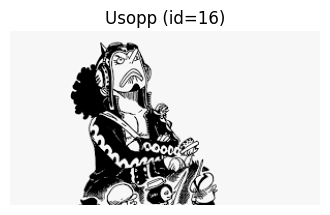

In [9]:
# случайная картинка
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]

print(f"Индекс: {idx}")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"{id2name[label]} (id={label})")
plt.axis("off")
plt.show()


## Анализ данных

Для начала рассмотрим, насколько представлен каждый класс

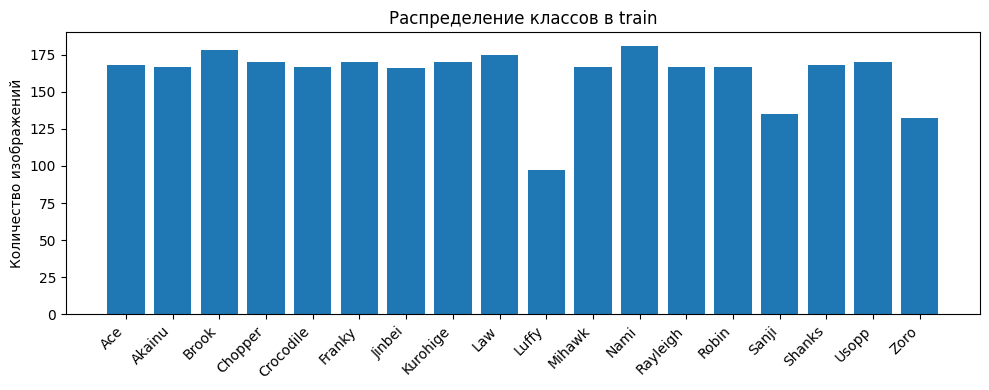

In [10]:
all_labels = [label for _, label in train_dataset]
cnt = Counter(all_labels)

rows = []
for class_id in sorted(cnt.keys()):
    name = id2name[class_id]
    count = cnt[class_id]
    rows.append((class_id, name, count))

ids = [r[0] for r in rows]
names = [r[1] for r in rows]
counts = [r[2] for r in rows]

plt.figure(figsize=(10, 4))
plt.bar(range(len(ids)), counts)
plt.xticks(range(len(ids)), names, rotation=45, ha="right")
plt.ylabel("Количество изображений")
plt.title("Распределение классов в train")
plt.tight_layout()
plt.show()

В целом, данные представлены примерно в равных долях (за исключением нескольких малопредставленных классов)


In [11]:
total = sum(cnt.values())
print(f"\nВсего изображений: {total}")

print("\nДоля каждого класса (%):")
for class_id in sorted(cnt.keys()):
    name = id2name[class_id]
    frac = cnt[class_id] / total * 100
    print(f"{name:10s}: {frac:6.2f}%")



Всего изображений: 2915

Доля каждого класса (%):
Ace       :   5.76%
Akainu    :   5.73%
Brook     :   6.11%
Chopper   :   5.83%
Crocodile :   5.73%
Franky    :   5.83%
Jinbei    :   5.69%
Kurohige  :   5.83%
Law       :   6.00%
Luffy     :   3.33%
Mihawk    :   5.73%
Nami      :   6.21%
Rayleigh  :   5.73%
Robin     :   5.73%
Sanji     :   4.63%
Shanks    :   5.76%
Usopp     :   5.83%
Zoro      :   4.53%


Также, при работе с изображениями, полезно изучить размеры картинок и соотношения сторон. Анализ даст понять, как сильно мы “ломаем” исходные данные при приведении их к фиксированному размеру для CNN. Если большинство картинок сильно вытянуты или очень большие, то простое Resize/CenterCrop будет либо искажать пропорции (менять соотношение сторон), либо агрессивно обрезать важные части. От этого модель может учиться хуже: часть объектов окажется обрезанной, а часть — искажённой.

Ширина:  min=63, max=3876, median=300.0
Высота:  min=77, max=6408, median=246.0
Соотн. сторон w/h: min=0.23, max=3.33, median=1.03


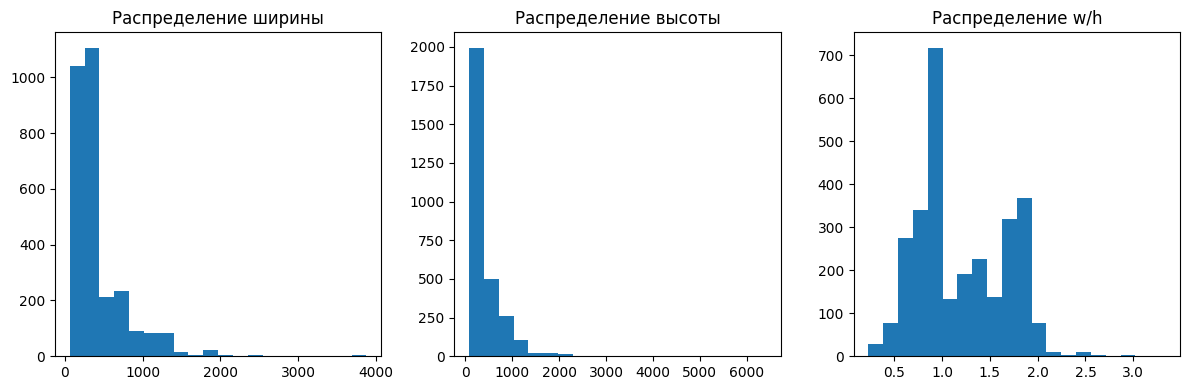

In [12]:
widths = []
heights = []
ratios = []

for img, _ in train_dataset:
    w, h = img.size  # PIL: (width, height)
    widths.append(w)
    heights.append(h)
    ratios.append(w / h)

widths = np.array(widths)
heights = np.array(heights)
ratios = np.array(ratios)

print(f"Ширина:  min={widths.min()}, max={widths.max()}, median={np.median(widths)}")
print(f"Высота:  min={heights.min()}, max={heights.max()}, median={np.median(heights)}")
print(f"Соотн. сторон w/h: min={ratios.min():.2f}, max={ratios.max():.2f}, median={np.median(ratios):.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=20)
plt.title("Распределение ширины")

plt.subplot(1, 3, 2)
plt.hist(heights, bins=20)
plt.title("Распределение высоты")

plt.subplot(1, 3, 3)
plt.hist(ratios, bins=20)
plt.title("Распределение w/h")

plt.tight_layout()
plt.show()


По данным видно, что большая часть изображений имеет умеренные размеры (медиана ширины ≈300, высоты ≈246), а распределения сильно скошены вправо: есть небольшой хвост очень больших картинок до 3–6k пикселей по одной из сторон. Соотношение сторон w/h имеет медиану ~1.03, а основной массив лежит примерно в диапазоне 0.75–1.5, то есть большинство картинок близки к квадратным, но есть и редкие экстремальные случаи (минимум 0.23 — очень “высокие”, максимум 3.33 — очень “широкие” изображения)

## Препроцессинг

Поскольку предобученная модель, рассматриваемая далее (ResNet) обучена на изображениях 224x224, изображения в этой выборке также будут представлены в таком масштабе. Предварительный Rescize до 256 нужен для небольшого "запаса" по краям, из которого можно будет делать случайный кроп, не обрезая важнейшие детали.

ResizedCrop нужен для того, чтобы разнообразить выборку и заставить модель работать с разным масштабом изображения - персонажи ближе/дальше - для устойчивости

Также, важно отметить, что горизонтальное отражение картинки не влияет на персонажей, поэтому так можно удвоить нашу выборку. Кроме того, добавляю небольшой наклон в картинки (до ~20 градусов, иначе их положение уже неестественно).

ColorJitter используется для того, чтобы сгладить разные "источники" изображений - комиксы, арты, скриншоты из оригинальных мультфильмов. Модель должна игнорировать изменения в яркости и цветах, сосредотачиваясь на формах и образах персонажей


Итоговый пайплайн: resize -> resizedCrop -> horizontalFlip -> rotation -> ColorJitter -> normalize



In [13]:
IMAGE_SIZE = 224

In [14]:
class TransformedDataset(Dataset):
    """
    Обёртка над базовым датасетом: применяет transform к картинке.
    """
    def __init__(self, base_dataset: Dataset, transform) -> None:
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img, label = self.base_dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [16]:
# для валидационной выборки только препроцессинг
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

## Подготовка к обучению

In [17]:
val_fraction = 0.2
num_samples = len(train_dataset)
num_val = int(num_samples * val_fraction)
num_train = num_samples - num_val

train_base, val_base = random_split(
    train_dataset,
    lengths=[num_train, num_val],
    generator=torch.Generator()
)

In [18]:
train_dataset = TransformedDataset(train_base, train_transform)
val_dataset = TransformedDataset(val_base, val_transform)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 2332, Val size: 583


In [19]:
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

len(train_loader), len(val_loader)

(19, 5)

## Эксперимент (ResNet18 + head)

In [ ]:
num_classes = len(id2name)

weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

# заменяю последний полносвязный слой под выходные классы
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)


In [22]:
# учу только голову
for name, param in model.named_parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params:,} / {all_params:,}")

Trainable params: 9,234 / 11,185,746


In [23]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4,
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="train", leave=True)

    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        # текущие средние значения по эпохе
        curr_loss = running_loss / max(total, 1)
        curr_acc = running_correct / max(total, 1)

        pbar.set_postfix(
            loss=f"{curr_loss:.4f}",
            acc=f"{curr_acc:.4f}",
        )

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="val", leave=True)

    with torch.no_grad():
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

            curr_loss = running_loss / max(total, 1)
            curr_acc = running_correct / max(total, 1)

            pbar.set_postfix(
                loss=f"{curr_loss:.4f}",
                acc=f"{curr_acc:.4f}",
            )

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc



train_history = {"loss": [], "acc": []}
val_history = {"loss": [], "acc": []}

best_val_acc = 0.0
best_state_dict = None

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

    scheduler.step()

    train_history["loss"].append(train_loss)
    train_history["acc"].append(train_acc)
    val_history["loss"].append(val_loss)
    val_history["acc"].append(val_acc)

    print(
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

print(f"\nBest val_acc: {best_val_acc:.4f}")



Epoch 1/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s, acc=0.2676, loss=2.4986]


train_loss=2.7579, train_acc=0.1522 | val_loss=2.4986, val_acc=0.2676

Epoch 2/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s, acc=0.4322, loss=2.1645]


train_loss=2.3254, train_acc=0.3722 | val_loss=2.1645, val_acc=0.4322

Epoch 3/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s, acc=0.5266, loss=1.9048]


train_loss=2.0139, train_acc=0.5086 | val_loss=1.9048, val_acc=0.5266

Epoch 4/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s, acc=0.5523, loss=1.7402]


train_loss=1.7990, train_acc=0.5798 | val_loss=1.7402, val_acc=0.5523

Epoch 5/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s, acc=0.5918, loss=1.6140]


train_loss=1.6322, train_acc=0.5973 | val_loss=1.6140, val_acc=0.5918

Epoch 6/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s, acc=0.5815, loss=1.5921]


train_loss=1.5333, train_acc=0.6557 | val_loss=1.5921, val_acc=0.5815

Epoch 7/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s, acc=0.5815, loss=1.5751]


train_loss=1.5018, train_acc=0.6660 | val_loss=1.5751, val_acc=0.5815

Epoch 8/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s, acc=0.5969, loss=1.5501]


train_loss=1.4926, train_acc=0.6664 | val_loss=1.5501, val_acc=0.5969

Epoch 9/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s, acc=0.6003, loss=1.5412]


train_loss=1.4756, train_acc=0.6702 | val_loss=1.5412, val_acc=0.6003

Epoch 10/10


val: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s, acc=0.5952, loss=1.5380]

train_loss=1.4713, train_acc=0.6685 | val_loss=1.5380, val_acc=0.5952

Best val_acc: 0.6003


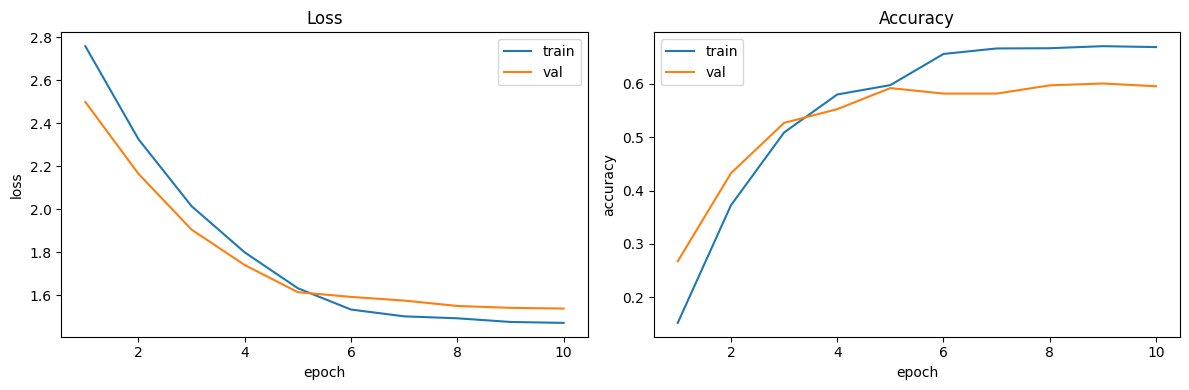

In [26]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_history["loss"], label="train")
plt.plot(epochs, val_history["loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_history["acc"], label="train")
plt.plot(epochs, val_history["acc"], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
def get_preds_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="val_infer", leave=True):
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_labels, all_preds

y_true_val, y_pred_val = get_preds_and_labels(model, val_loader, device)


val_infer: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Классификационный отчёт на val:
              precision    recall  f1-score   support

         Ace     0.6190    0.4062    0.4906        32
      Akainu     0.8696    0.5714    0.6897        35
       Brook     0.8158    0.7750    0.7949        40
     Chopper     0.6923    0.9310    0.7941        29
   Crocodile     0.7143    0.3125    0.4348        32
      Franky     0.5294    0.6000    0.5625        30
      Jinbei     0.5135    0.7917    0.6230        24
    Kurohige     0.5667    0.5484    0.5574        31
         Law     0.9444    0.4722    0.6296        36
       Luffy     0.8333    0.2174    0.3448        23
      Mihawk     0.7391    0.4474    0.5574        38
        Nami     0.6167    0.9024    0.7327        41
    Rayleigh     0.5385    0.6829    0.6022        41
       Robin     0.3934    0.6000    0.4752        40
       Sanji     0.6471    0.8148    0.7213        27
      Shanks     0.4750    0.5588    0.5135        34
       Usopp     0.3077    0.5217    0.3871      

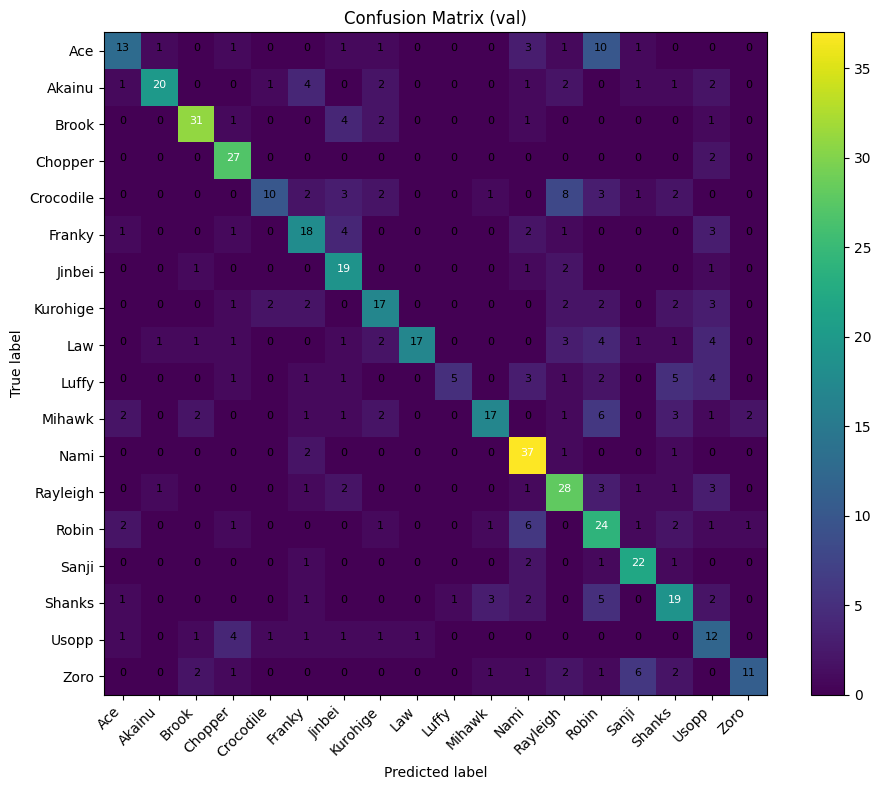

In [32]:
target_names = [id2name[i] for i in range(len(id2name))]

print("Классификационный отчёт на val:")
print(classification_report(y_true_val, y_pred_val, target_names=target_names, digits=4))

cm = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (val)")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha="right")
plt.yticks(tick_marks, target_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Обучение на всей выборке + сабмит

In [34]:
full_dataset = OnePieceImageDataset(TRAIN_DIR, name2id)
full_train_dataset = TransformedDataset(full_dataset, train_transform)

full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

len(full_train_dataset), len(full_train_loader)


Loaded 2915 samples from data/one-piece-classification-2025\splitted\train


(2915, 23)

In [35]:
final_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = final_model.fc.in_features
final_model.fc = nn.Linear(in_features, num_classes)

for name, param in final_model.named_parameters():
    param.requires_grad = False
for param in final_model.fc.parameters():
    param.requires_grad = True

final_model = final_model.to(device)

final_criterion = nn.CrossEntropyLoss()
final_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, final_model.parameters()),
    lr=1e-3,
    weight_decay=1e-4,
)
final_scheduler = torch.optim.lr_scheduler.StepLR(final_optimizer, step_size=5, gamma=0.1)

final_epochs = 20

for epoch in range(1, final_epochs + 1):
    print(f"\n[FINAL] Epoch {epoch}/{final_epochs}")
    train_loss, train_acc = train_one_epoch(final_model, full_train_loader, final_criterion, final_optimizer, device)
    final_scheduler.step()
    print(f"[FINAL] train_loss={train_loss:.4f}, train_acc={train_acc:.4f}")




[FINAL] Epoch 1/20


train: 100%|██████████| 23/23 [00:23<00:00,  1.00s/it, acc=0.1407, loss=2.7643]


[FINAL] train_loss=2.7643, train_acc=0.1407

[FINAL] Epoch 2/20


train: 100%|██████████| 23/23 [00:23<00:00,  1.02s/it, acc=0.3973, loss=2.2518]


[FINAL] train_loss=2.2518, train_acc=0.3973

[FINAL] Epoch 3/20


train: 100%|██████████| 23/23 [00:22<00:00,  1.00it/s, acc=0.5376, loss=1.9102]


[FINAL] train_loss=1.9102, train_acc=0.5376

[FINAL] Epoch 4/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, acc=0.6096, loss=1.6739]


[FINAL] train_loss=1.6739, train_acc=0.6096

[FINAL] Epoch 5/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6384, loss=1.5314]


[FINAL] train_loss=1.5314, train_acc=0.6384

[FINAL] Epoch 6/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.05it/s, acc=0.6652, loss=1.4378]


[FINAL] train_loss=1.4378, train_acc=0.6652

[FINAL] Epoch 7/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6762, loss=1.4148]


[FINAL] train_loss=1.4148, train_acc=0.6762

[FINAL] Epoch 8/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6768, loss=1.4084]


[FINAL] train_loss=1.4084, train_acc=0.6768

[FINAL] Epoch 9/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.05it/s, acc=0.6796, loss=1.3956]


[FINAL] train_loss=1.3956, train_acc=0.6796

[FINAL] Epoch 10/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6923, loss=1.3634]


[FINAL] train_loss=1.3634, train_acc=0.6923

[FINAL] Epoch 11/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, acc=0.6847, loss=1.3698]


[FINAL] train_loss=1.3698, train_acc=0.6847

[FINAL] Epoch 12/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6827, loss=1.3687]


[FINAL] train_loss=1.3687, train_acc=0.6827

[FINAL] Epoch 13/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, acc=0.6861, loss=1.3527]


[FINAL] train_loss=1.3527, train_acc=0.6861

[FINAL] Epoch 14/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6744, loss=1.3769]


[FINAL] train_loss=1.3769, train_acc=0.6744

[FINAL] Epoch 15/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6792, loss=1.3714]


[FINAL] train_loss=1.3714, train_acc=0.6792

[FINAL] Epoch 16/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6861, loss=1.3559]


[FINAL] train_loss=1.3559, train_acc=0.6861

[FINAL] Epoch 17/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, acc=0.6858, loss=1.3723]


[FINAL] train_loss=1.3723, train_acc=0.6858

[FINAL] Epoch 18/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.06it/s, acc=0.6844, loss=1.3763]


[FINAL] train_loss=1.3763, train_acc=0.6844

[FINAL] Epoch 19/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6878, loss=1.3539]


[FINAL] train_loss=1.3539, train_acc=0.6878

[FINAL] Epoch 20/20


train: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s, acc=0.6738, loss=1.3703]

[FINAL] train_loss=1.3703, train_acc=0.6738


In [36]:
torch.save(final_model.state_dict(), "resnet18_first_submit.pth")

In [42]:
class TestImageDataset(Dataset):
    def __init__(self, root_dir: str, transform) -> None:
        self.root_dir = root_dir
        self.transform = transform
        self.paths = []

        for fname in os.listdir(root_dir):
            path = os.path.join(root_dir, fname)
            if os.path.isfile(path) and fname.lower().endswith(IMAGE_EXTENSIONS):
                self.paths.append(path)

        print(f"Loaded {len(self.paths)} test images from {root_dir}")

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        fname = os.path.basename(path)
        return img, fname


In [43]:
test_dataset = TestImageDataset(TEST_DIR, val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)
len(test_dataset), len(test_loader)

Loaded 849 test images from data/one-piece-classification-2025\splitted\test


(849, 7)

In [ ]:
submission_rows = []

with torch.no_grad():
    for x, fnames in tqdm(test_loader, desc="submission", leave=True):
        x = x.to(device)
        logits = final_model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        for fname, pred_idx in zip(fnames, preds):
            submission_rows.append({
                "fname": fname,          # с расширением
                "label": int(pred_idx),  # id класса 0..17
            })

pred_by_fname = {row["fname"]: row["label"] for row in submission_rows}


submission: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


In [ ]:
ordered_rows = []

for fname in sorted(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, fname)
    if not os.path.isfile(path):
        continue
    if not fname.lower().endswith(IMAGE_EXTENSIONS):
        continue

    label_id = pred_by_fname[fname]        
    file_id = os.path.splitext(fname)[0]     

    ordered_rows.append({
        "id": file_id,
        "label": label_id,
    })

submission_df = pd.DataFrame(ordered_rows)
submission_df.to_csv("submission_resnet18_final.csv", index=False)
submission_df.head()


,id,label
0,002999fb-803d-45b2-b647-6203e446e475,2
1,00479183-ca4e-49c1-927d-f7209ff23145,11
2,0048719e-24d9-4a5a-af75-ca62c2e90477,13
3,00c99fe0-e1c9-48ef-8d16-1ea380f190cd,6
4,00efbf59-d4c4-4d7e-8bc6-86af36367515,10
